In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


.\binning_transformers.joblib
.\customer-churn-table.csv
.\dev.ipynb
.\df_feature_selection.csv
.\df_model_ready.csv
.\df_numeric_transformed.csv
.\df_transformed.csv
.\visualize.py
.\models\calibrated_model_20250910_162553.joblib


In [2]:
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE, SMOTENC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from datetime import datetime

import shap
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

c:\Users\parallax360\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('./customer-churn-table.csv')
display(df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
display(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
# Encode Categorical Features
categorical_features = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
label_features = ["Contract", "PaymentMethod"]
phoneServiceDependent = ["MultipleLines"]
internetServiceDependent = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

In [7]:
for feature in label_features:
    display(df[feature].value_counts())

Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: count, dtype: int64

PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: count, dtype: int64

In [8]:
multiplelines_mapping = {"No phone service": -1, "No": 0, "Yes": 1}
internet_mapping = {"No": 0, "Fiber optic": 1, "DSL": 2}
gender_mapping = {"Female": 2, "Male": 1}
internet_services_mapping = {"No": 0, "Yes": 1, "No internet service": -1}

df_transformed = df.drop(columns=["customerID"], axis=1)

# Scale Tenure, Monthly Charges, and Total Charges
# df_transformed['tenure_sqrt'] = np.sqrt(df_transformed['tenure'])
# df_transformed['MonthlyCharges_sqrt'] = np.sqrt(df_transformed['MonthlyCharges'])
# df_transformed['TotalCharges_sqrt'] = df_transformed['tenure_sqrt'] * df_transformed['MonthlyCharges_sqrt']

# Label Encode Features
le = LabelEncoder()
for feature in label_features:
    label = feature
    df_transformed[label] = le.fit_transform(df_transformed[feature])

df_transformed[categorical_features] = df_transformed[categorical_features].replace({'Yes': 1, 'No': 0})
df_transformed["MultipleLines"] = df_transformed["MultipleLines"].replace(multiplelines_mapping)
df_transformed["InternetService"] = df_transformed["InternetService"].replace(internet_mapping)
df_transformed["gender"] = df_transformed["gender"].replace(gender_mapping)
for feature in internetServiceDependent:
    df_transformed[feature] = df_transformed[feature].replace(internet_services_mapping)

df_transformed["Has_Internet"] = df_transformed["InternetService"].apply(lambda x: 1 if x != 0 else 0)
df_transformed["Contract_Long"] = df_transformed["Contract"].apply(lambda x: 1 if x != 0 else 0)
df_transformed["Contract_Short"] = df_transformed["Contract"].apply(lambda x: 0 if x != 0 else 1)
df_transformed.head(15)

C:\Users\hitma\AppData\Local\Temp\ipykernel_34424\2857749032.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[categorical_features] = df_transformed[categorical_features].replace({'Yes': 1, 'No': 0})
C:\Users\hitma\AppData\Local\Temp\ipykernel_34424\2857749032.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed["MultipleLines"] = df_transformed["MultipleLines"].replace(multiplelines_mapping)
C:\Users\hitma\AppData\Local\Temp\ipykernel_34424\2857749032.py:21: FutureWarning: Downcasting behavior in

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Has_Internet,Contract_Long,Contract_Short
0,2,0,1,0,1,0,-1,2,0,1,...,0,0,1,2,29.85,29.85,0,1,0,1
1,1,0,0,0,34,1,0,2,1,0,...,0,1,0,3,56.95,1889.50,0,1,1,0
2,1,0,0,0,2,1,0,2,1,1,...,0,0,1,3,53.85,108.15,1,1,0,1
3,1,0,0,0,45,0,-1,2,1,0,...,0,1,0,0,42.30,1840.75,0,1,1,0
4,2,0,0,0,2,1,0,1,0,0,...,0,0,1,2,70.70,151.65,1,1,0,1
5,2,0,0,0,8,1,1,1,0,0,...,1,0,1,2,99.65,820.50,1,1,0,1
6,1,0,0,1,22,1,1,1,0,1,...,0,0,1,1,89.10,1949.40,0,1,0,1
7,2,0,0,0,10,0,-1,2,1,0,...,0,0,0,3,29.75,301.90,0,1,0,1
8,2,0,1,0,28,1,1,1,0,0,...,1,0,1,2,104.80,3046.05,1,1,0,1
9,1,0,0,1,62,1,0,2,1,1,...,0,1,0,0,56.15,3487.95,0,1,1,0


In [9]:
df_transformed["MultipleLines"] = df_transformed["MultipleLines"] * df_transformed["PhoneService"]
df_transformed[["PhoneService", "MultipleLines"]].head(10)

,PhoneService,MultipleLines
0,0,0
1,1,0
2,1,0
3,0,0
4,1,0
5,1,1
6,1,1
7,0,0
8,1,1
9,1,0


In [10]:
df_transformed.info()

# Save df_transformed to csv
df_transformed.to_csv("df_transformed.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int32  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int32  
 17  

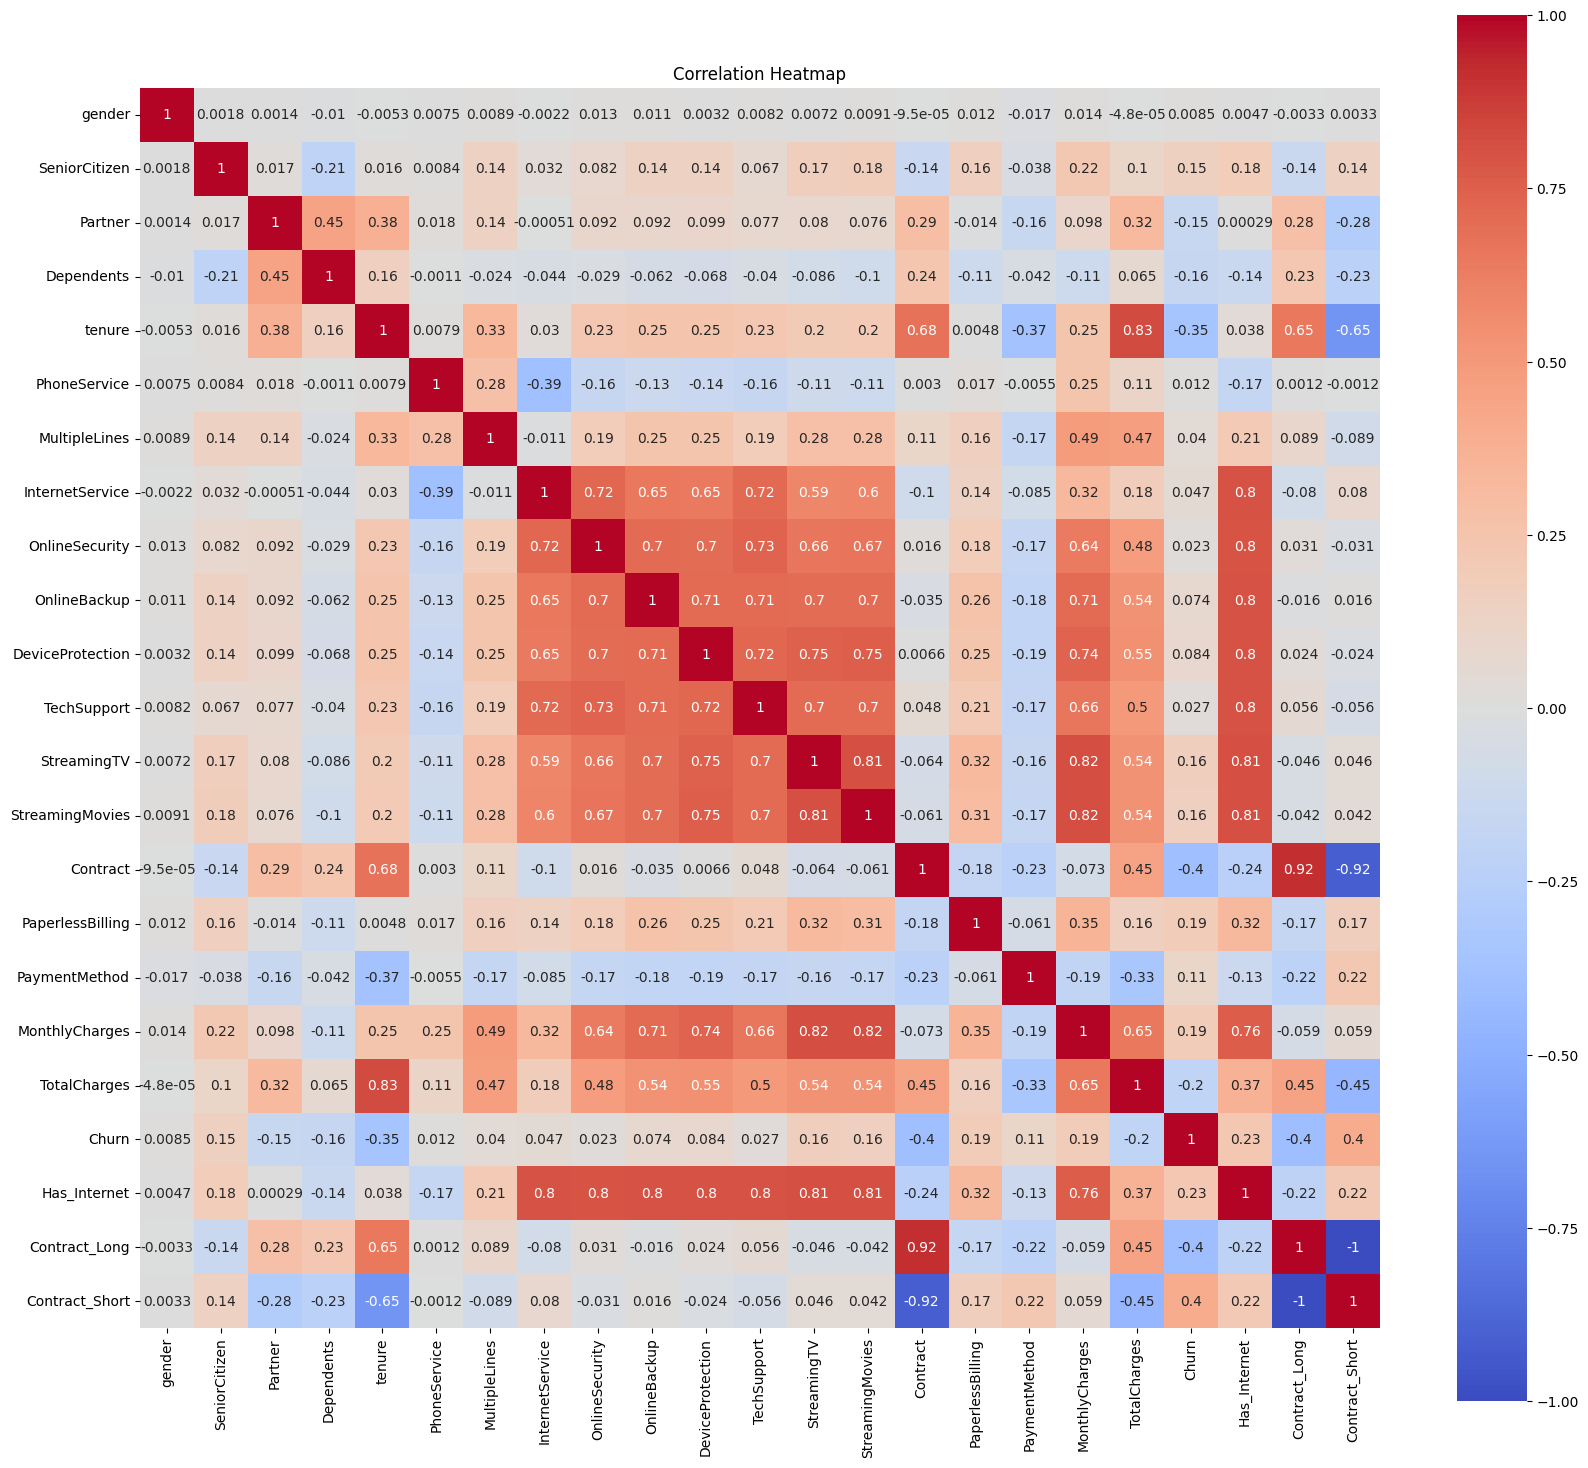

In [11]:
corr_matrix = df_transformed.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

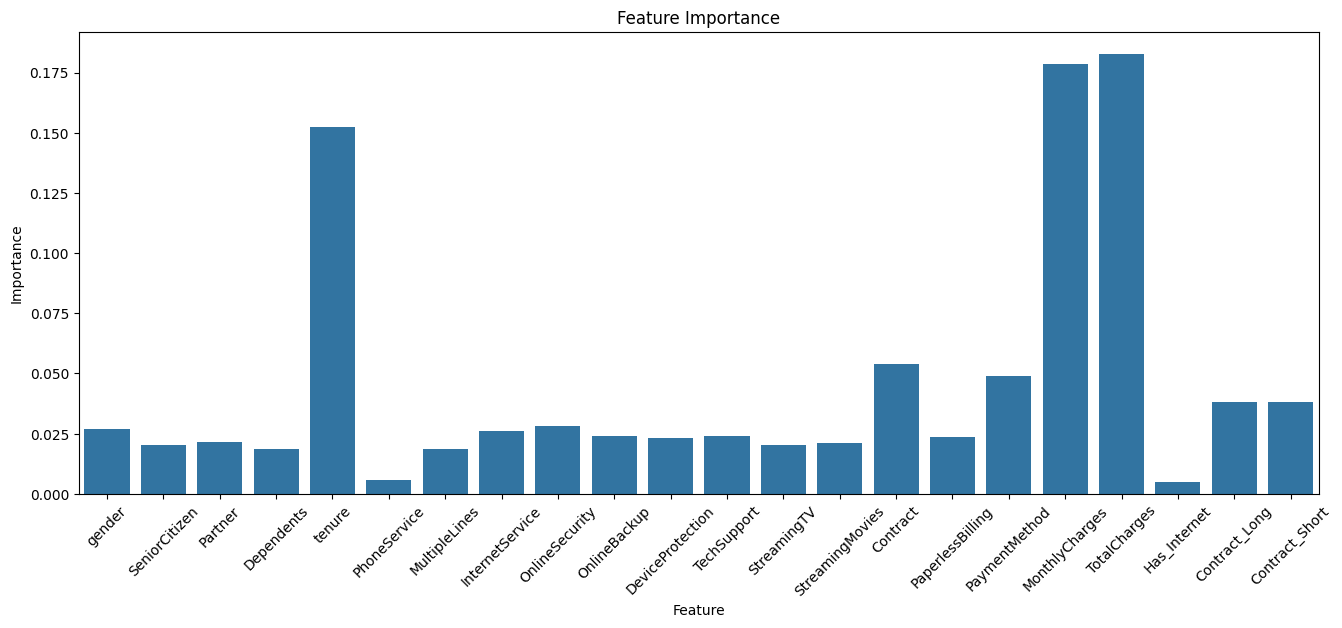

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df_transformed.drop('Churn', axis=1), df_transformed['Churn'])

feature_importances = rf.feature_importances_
feature_names = df_transformed.drop('Churn', axis=1).columns

plt.figure(figsize=(16, 6))
sns.barplot(x=feature_names, y=feature_importances)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.ylabel('Importance')
plt.show()

In [13]:
corr_matrix = df_transformed.corr()
churn_correlations = corr_matrix['Churn'].abs().sort_values(ascending=False)
display("Absolute Correlations with Churn:")
display(churn_correlations)

'Absolute Correlations with Churn:'

Churn               1.000000
Contract_Long       0.404565
Contract_Short      0.404565
Contract            0.396150
tenure              0.354049
Has_Internet        0.227578
TotalCharges        0.199484
MonthlyCharges      0.192858
PaperlessBilling    0.191454
StreamingTV         0.164509
Dependents          0.163128
StreamingMovies     0.162672
SeniorCitizen       0.150541
Partner             0.149982
PaymentMethod       0.107852
DeviceProtection    0.084402
OnlineBackup        0.073934
InternetService     0.047097
MultipleLines       0.040033
TechSupport         0.026744
OnlineSecurity      0.023014
PhoneService        0.011691
gender              0.008545
Name: Churn, dtype: float64

In [14]:
drop_redundant = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines", "PaperlessBilling", "gender"]
df_feature_selection = df_transformed.drop(columns=drop_redundant, axis=1)
df_feature_selection.head(10)
df_feature_selection.to_csv("df_feature_selection.csv", index=False)

In [15]:
display(df_feature_selection["Churn"].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64

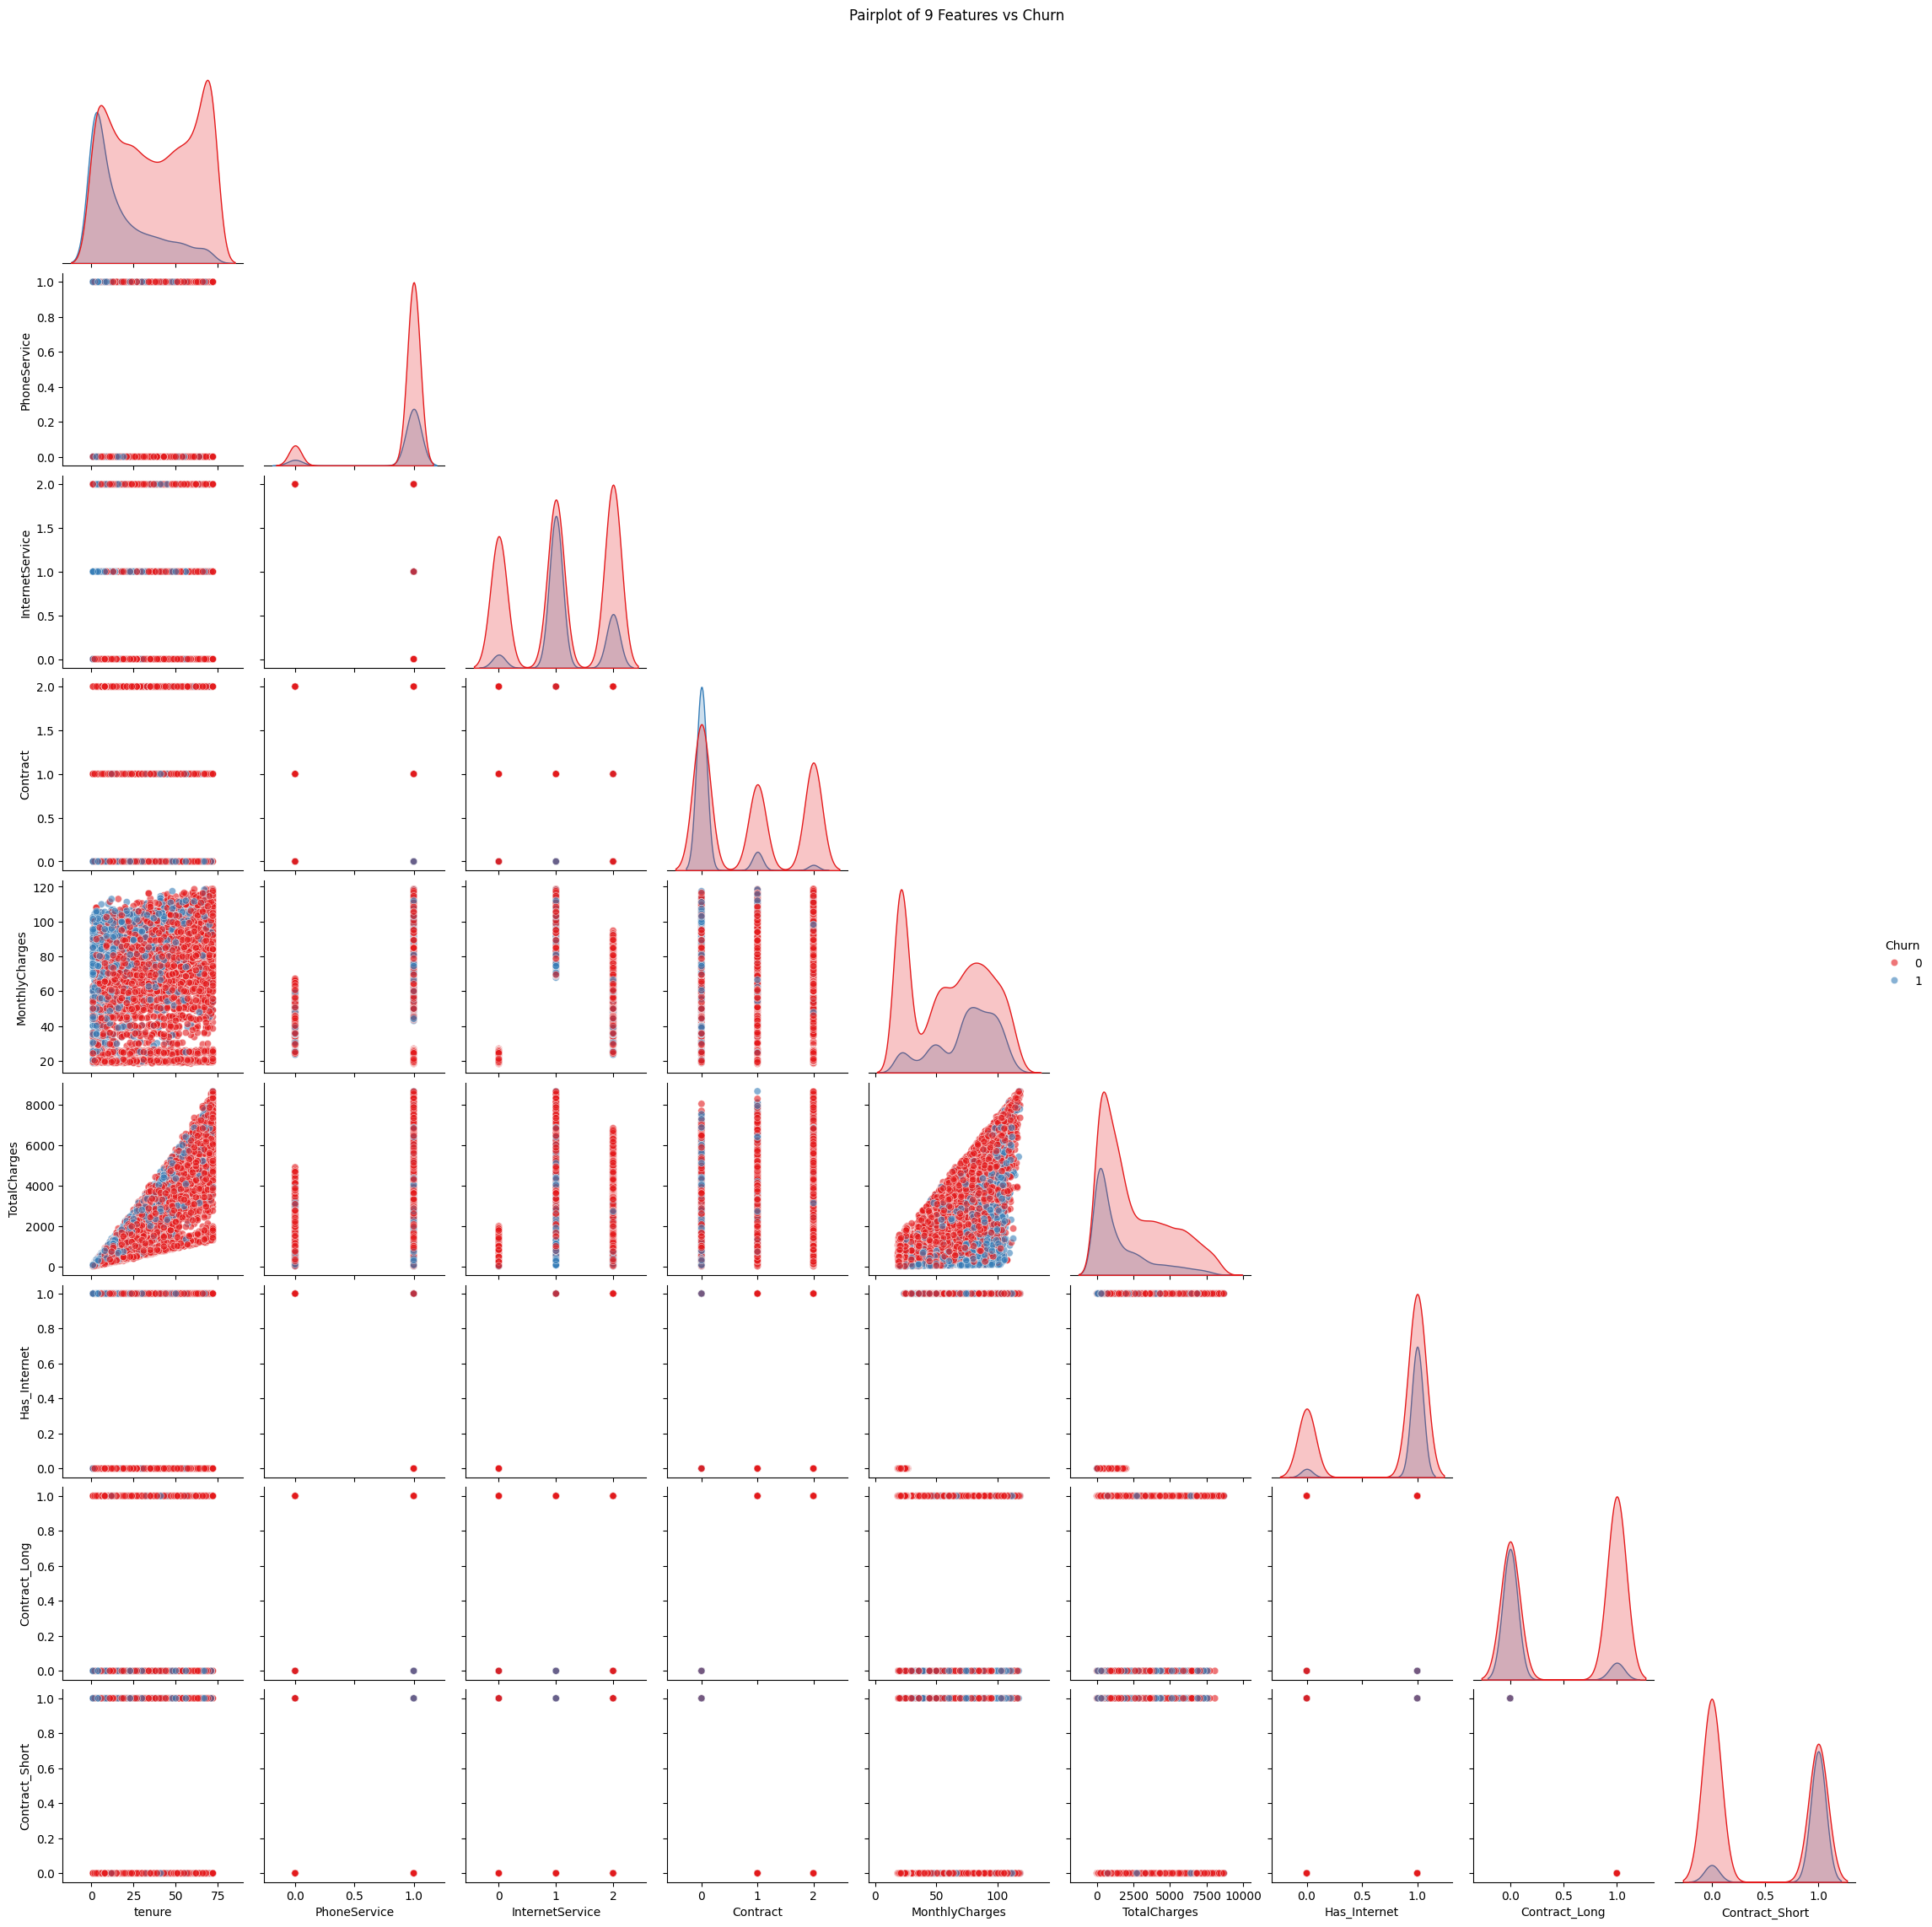

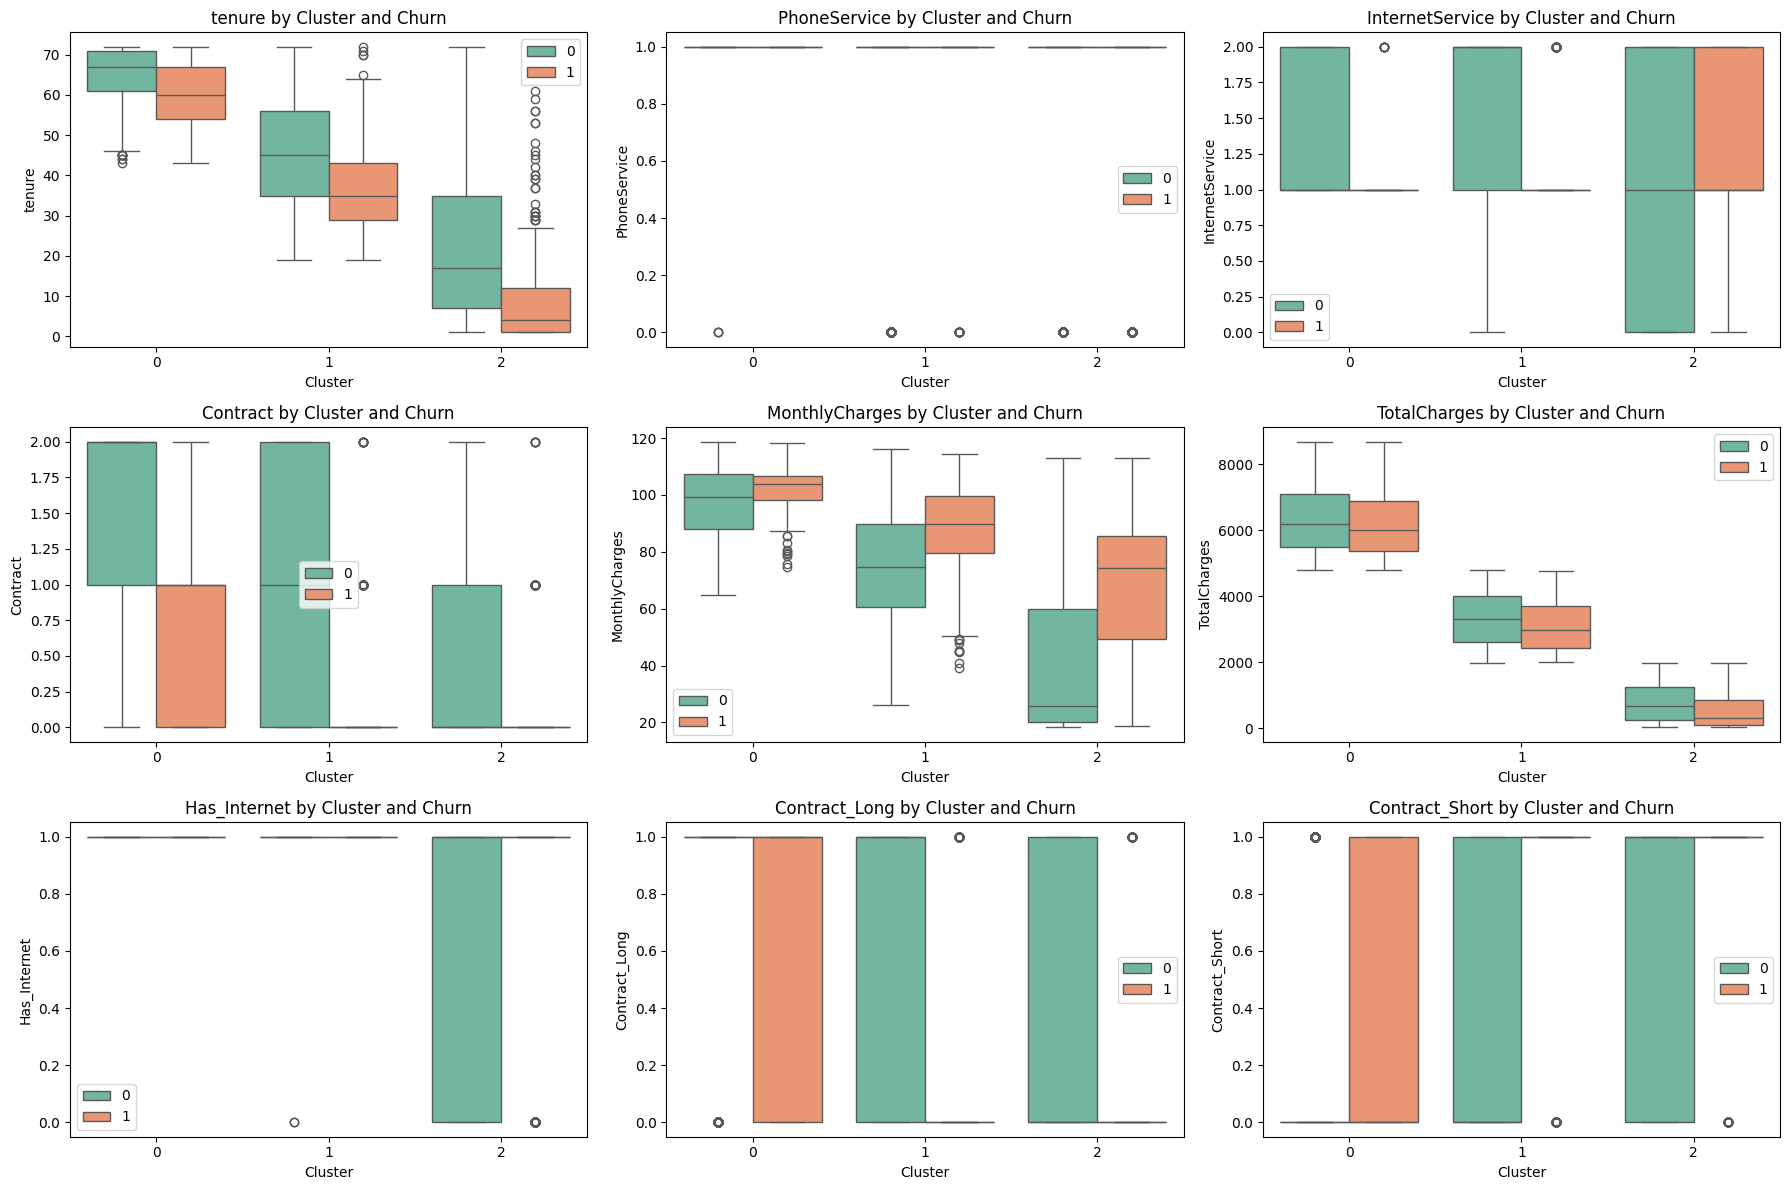

In [16]:
# KMeans clustering and feature visualization against Churn
# from sklearn.cluster import KMeans
# import seaborn as sns
# import matplotlib.pyplot as plt

# Select 9 features and Churn for visualization (update with your actual feature names)
# features_to_plot = df_feature_selection.drop('Churn', axis=1).columns[:9].tolist() 
features_to_plot = df_feature_selection.columns[[3, 4, 5, 6, 8, 9, 11, 12, 13]].tolist()  # first 9 features
plot_df = df_feature_selection[features_to_plot + ['Churn']].copy()

# Fit KMeans
n_clusters = 3  # You can change this number as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
plot_df['Cluster'] = kmeans.fit_predict(plot_df[features_to_plot])

# Pairplot: features vs Churn, colored by cluster
sns.pairplot(plot_df, vars=features_to_plot, hue='Churn', palette='Set1', corner=True, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Pairplot of 9 Features vs Churn', y=1.02)
plt.show()

# Boxplot: feature distributions by cluster and Churn
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, feature in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    sns.boxplot(x='Cluster', y=feature, hue='Churn', data=plot_df, ax=ax, palette='Set2')
    ax.set_title(f'{feature} by Cluster and Churn')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
df_feature_selection[["MonthlyCharges", "TotalCharges"]].describe()

,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000
mean,64.798208,2283.300441
std,30.085974,2266.771362
min,18.250000,18.800000
25%,35.587500,401.450000
50%,70.350000,1397.475000
75%,89.862500,3794.737500
max,118.750000,8684.800000


In [18]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(df[column].min(), Q1 - 1.5 * IQR)
    upper_bound = min(df[column].max(), Q3 + 1.5 * IQR)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from both columns
df_clean = df_feature_selection.copy()
df_clean = remove_outliers_iqr(df_clean, 'MonthlyCharges')
df_clean = remove_outliers_iqr(df_clean, 'TotalCharges')

print(f"Original shape: {df_feature_selection.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(f"Rows removed: {len(df_feature_selection) - len(df_clean)}")

Original shape: (7032, 14)
Cleaned shape: (7032, 14)
Rows removed: 0


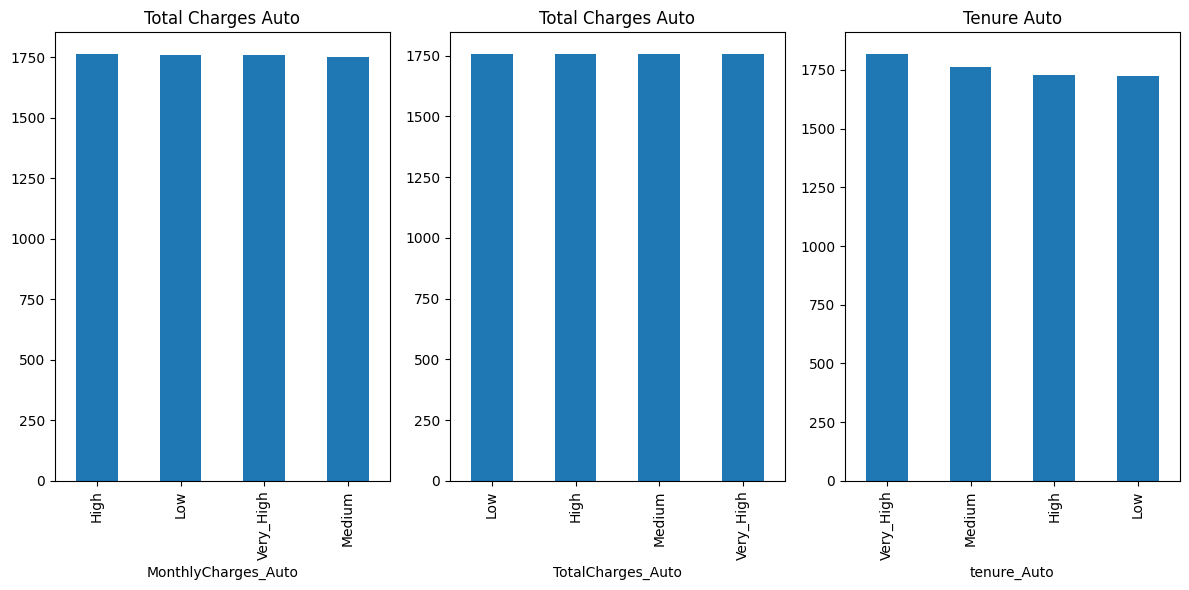

MonthlyCharges bin edges: [ 18.25    35.5875  70.35    89.8625 118.75  ]
TotalCharges bin edges: [  18.8     401.45   1397.475  3794.7375 8684.8   ]
Tenure bin edges: [ 1.  9. 29. 55. 72.]


['binning_transformers.joblib']

In [63]:
df_binning = df_clean[['MonthlyCharges', 'TotalCharges', 'tenure']].copy()

# For MonthlyCharges
monthly_binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_binning['MonthlyCharges_Auto'] = monthly_binner.fit_transform(df_binning[['MonthlyCharges']]).astype(int)
# df_binning['MonthlyCharges'] = monthly_binner.fit_transform(df_binning[['MonthlyCharges']]).astype(int)

# For TotalCharges  
total_binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_binning['TotalCharges_Auto'] = total_binner.fit_transform(df_binning[['TotalCharges']]).astype(int)
# df_binning['TotalCharges'] = total_binner.fit_transform(df_binning[['TotalCharges']]).astype(int)

# For tenure  
tenure_binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_binning['tenure_Auto'] = tenure_binner.fit_transform(df_binning[['tenure']]).astype(int)
# df_binning['tenure'] = tenure_binner.fit_transform(df_binning[['tenure']]).astype(int)

# Map to meaningful labels
bin_labels = {0: 'Low', 1: 'Medium', 2: 'High', 3: 'Very_High'}
df_binning['MonthlyCharges_Auto'] = df_binning['MonthlyCharges_Auto'].map(bin_labels)
df_binning['Monthly_VeryHigh'] = df_binning['MonthlyCharges_Auto'] == 'Very_High'
df_binning['Monthly_High'] = df_binning['MonthlyCharges_Auto'] == 'High'
df_binning['Monthly_Medium'] = df_binning['MonthlyCharges_Auto'] == 'Medium'
df_binning['Monthly_Low'] = df_binning['MonthlyCharges_Auto'] == 'Low'

df_binning['TotalCharges_Auto'] = df_binning['TotalCharges_Auto'].map(bin_labels)
df_binning['Total_VeryHigh'] = df_binning['TotalCharges_Auto'] == 'Very_High'
df_binning['Total_High'] = df_binning['TotalCharges_Auto'] == 'High'
df_binning['Total_Medium'] = df_binning['TotalCharges_Auto'] == 'Medium'
df_binning['Total_Low'] = df_binning['TotalCharges_Auto'] == 'Low'

df_binning['tenure_Auto'] = df_binning['tenure_Auto'].map(bin_labels)
df_binning['tenure_VeryHigh'] = df_binning['tenure_Auto'] == 'Very_High'
df_binning['tenure_High'] = df_binning['tenure_Auto'] == 'High'
df_binning['tenure_Medium'] = df_binning['tenure_Auto'] == 'Medium'
df_binning['tenure_Low'] = df_binning['tenure_Auto'] == 'Low'

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
df_binning['MonthlyCharges_Auto'].value_counts().plot(kind='bar')
plt.title('Total Charges Auto')

plt.subplot(1, 3, 2)
df_binning['TotalCharges_Auto'].value_counts().plot(kind='bar')
plt.title('Total Charges Auto')

plt.subplot(1, 3, 3)
df_binning['tenure_Auto'].value_counts().plot(kind='bar')
plt.title('Tenure Auto')
plt.tight_layout()
plt.show()

df_binning = df_binning.drop(columns=['MonthlyCharges', 'TotalCharges', 'tenure'], axis=1)

# Convert bool features to int
df_binning['Monthly_VeryHigh'] = df_binning['Monthly_VeryHigh'].astype(int)
df_binning['Monthly_High'] = df_binning['Monthly_High'].astype(int)
df_binning['Monthly_Medium'] = df_binning['Monthly_Medium'].astype(int)
df_binning['Monthly_Low'] = df_binning['Monthly_Low'].astype(int)

df_binning['Total_VeryHigh'] = df_binning['Total_VeryHigh'].astype(int)
df_binning['Total_High'] = df_binning['Total_High'].astype(int)
df_binning['Total_Medium'] = df_binning['Total_Medium'].astype(int)
df_binning['Total_Low'] = df_binning['Total_Low'].astype(int)

df_binning['tenure_VeryHigh'] = df_binning['tenure_VeryHigh'].astype(int)
df_binning['tenure_High'] = df_binning['tenure_High'].astype(int)
df_binning['tenure_Medium'] = df_binning['tenure_Medium'].astype(int)
df_binning['tenure_Low'] = df_binning['tenure_Low'].astype(int)

# Get the bin edges for each feature
monthly_bin_edges = monthly_binner.bin_edges_[0]
total_bin_edges = total_binner.bin_edges_[0]
tenure_bin_edges = tenure_binner.bin_edges_[0]  # Since you reused the same transformer

print("MonthlyCharges bin edges:", monthly_bin_edges)
print("TotalCharges bin edges:", total_bin_edges)
print("Tenure bin edges:", tenure_bin_edges)

# After fitting your binning transformers
binning_transformers = {
    'monthly_binner': monthly_binner,
    'total_binner': total_binner,
    'tenure_binner': tenure_binner  # Note: you reused total_binner for tenure
}

joblib.dump(binning_transformers, 'binning_transformers.joblib')

In [64]:
tenure_bin = binning_transformers["tenure_binner"].transform([[32.0]])[0][0].astype(int)
tenure_bin

c:\Program Files\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KBinsDiscretizer was fitted with feature names
  warnings.warn(


2

In [20]:
# Concat df_binning's monthly charges, total charges, and tenure in df_clean
df_numeric_transformed = pd.concat([df_clean.drop(columns=['tenure', 'TotalCharges', 'MonthlyCharges', 'Dependents', 'Partner', 'SeniorCitizen', 'PhoneService', 'Contract', 'InternetService'], axis=1), df_binning.drop(columns=['TotalCharges_Auto', 'MonthlyCharges_Auto', 'tenure_Auto'])], axis=1)
df_numeric_transformed.head(5)
df_numeric_transformed.to_csv("df_numeric_transformed.csv", index=False)

In [21]:
final_features_drop = ['Total_VeryHigh', 'Total_High', 'Total_Medium', 'Total_Low', 'Monthly_High', 'tenure_Medium']
df_model_ready = df_numeric_transformed.drop(columns=final_features_drop, axis=1)

# --- Step 2: Split by class ---
class_0 = df_model_ready[df_model_ready["Churn"] == 0]
class_1 = df_model_ready[df_model_ready["Churn"] == 1]
majority, minority = class_0, class_1

# --- Step 3: Downsample majority to match minority ---
majority_down = majority.sample(n=len(minority), random_state=42)

# Balanced dataset (for splitting)
df_balanced = pd.concat([majority_down, minority], axis=0)

# Prepare features and target
X = df_balanced.drop('Churn', axis=1)
y = df_balanced['Churn']

# Display columns with their index
for i, col in enumerate(X.columns):
    print(f"{i}: {col}")

sample_weights = np.ones(len(X.columns))

# --- Step 4: Train-test split on balanced set ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# --- Step 5: Add back the leftover majority samples into train set ---
majority_leftover = majority.drop(majority_down.index)
X_train = pd.concat([X_train, majority_leftover.drop(columns=['Churn'], axis=1)], axis=0)
y_train = pd.concat([y_train, majority_leftover['Churn']], axis=0)

# Create a SMOTE object
smote = SMOTE()

# Fit the SMOTE object to the data and transform it
X_train, y_train = smote.fit_resample(X_train, y_train)

# Create a new dataframe with the resampled data
df_resampled = pd.concat([X_train, y_train], axis=1)

# Print the class distribution of the resampled data
print(df_resampled['Churn'].value_counts())

# Decision Tree model training and evaluation on df_model_ready

# Train Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predict and evaluate
y_pred = dt.predict(X_test)

print('\nClassification Report:')
print(classification_report(y_test, y_pred))
df_model_ready.to_csv("df_model_ready.csv", index=False)

0: PaymentMethod
1: Has_Internet
2: Contract_Long
3: Contract_Short
4: Monthly_VeryHigh
5: Monthly_Medium
6: Monthly_Low
7: tenure_VeryHigh
8: tenure_High
9: tenure_Low
Churn
1    4415
0    4415
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       748
           1       0.74      0.74      0.74       748

    accuracy                           0.74      1496
   macro avg       0.74      0.74      0.74      1496
weighted avg       0.74      0.74      0.74      1496



In [22]:
xgb_weights = sample_weights.copy()
xgb_weights[0] = 0
xgb_weights[1] = 2
xgb_weights[3] = 0.4
xgb_weights[4] = 2

lgbm_weights = sample_weights.copy()
lgbm_weights[0] = 0
lgbm_weights[1] = 1.8
lgbm_weights[2] = 2.5
lgbm_weights[3] = 0.4
lgbm_weights[4] = 2.5
lgbm_weights[5] = 0.6
lgbm_weights[7] = 2.5



In [23]:
# ==============================
# 1. Define Training Models
# ==============================
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
)

# ==============================
# 2. Hyperparameter Search Space
# ==============================
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'sample_weights': [xgb_weights],
    'scale_pos_weight': [1]  # Already balanced with SMOTE, keep 1
}

# ==============================
# 3. RandomizedSearchCV with Stratified K-Fold
# ==============================
cv = StratifiedKFold(n_splits=10, shuffle=True)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='precision',  # Focus on F1 for churn
    n_iter=25,     # Try 50 combinations
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best Params
print("Best Parameters:", random_search.best_params_)
best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold (based on F1): {best_threshold:.2f}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion Matrix Heatmap
print("Confusion Matrix:\n", cm)


Fitting 10 folds for each of 25 candidates, totalling 250 fits


C:\Users\hitma\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [15:11:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sample_weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'sample_weights': array([0. , 2. , 1. , 0.4, 2. , 1. , 1. , 1. , 1. , 1. ]), 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
Optimal Threshold (based on F1): 0.48
Precision: 0.75
Recall: 0.78
F1 Score: 0.76
ROC AUC: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76       748
           1       0.75      0.78      0.76       748

    accuracy                           0.76      1496
   macro avg       0.76      0.76      0.76      1496
weighted avg       0.76      0.76      0.76      1496

Confusion Matrix:
 [[555 193]
 [167 581]]


In [24]:
# ==============================
# 1. Define Training Models
# ==============================
cb_model = CatBoostClassifier(
    loss_function='Logloss',   # default for binary classification
    eval_metric='Logloss',
    random_state=42,
)

# ==============================
# 2. Hyperparameter Search Space
# ==============================
param_dist = {
     'iterations': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [3, 5, 7, 9],
    'l2_leaf_reg': [0, 0.1, 0.5, 1],
    'border_count': [32, 64, 128, 256],
    'random_strength': [0, 1, 5, 10],
    # 'class_weights': [[1, 3]]
}

# ==============================
# 3. RandomizedSearchCV with Stratified K-Fold
# ==============================
cv = StratifiedKFold(n_splits=10, shuffle=True)

random_search = RandomizedSearchCV(
    estimator=cb_model,
    param_distributions=param_dist,
    scoring='precision',  # Focus on F1 for churn
    n_iter=20,     # Try 50 combinations
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best Params
print("Best Parameters:", random_search.best_params_)
best_cb_model = random_search.best_estimator_

y_pred = best_cb_model.predict(X_test)
y_proba = best_cb_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold (based on F1): {best_threshold:.2f}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion Matrix Heatmap
print("Confusion Matrix:\n", cm)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
0:	learn: 0.6731613	total: 148ms	remaining: 59.1s
1:	learn: 0.6556731	total: 152ms	remaining: 30.3s
2:	learn: 0.6401324	total: 164ms	remaining: 21.7s
3:	learn: 0.6265642	total: 168ms	remaining: 16.6s
4:	learn: 0.6146132	total: 171ms	remaining: 13.5s
5:	learn: 0.6046230	total: 175ms	remaining: 11.5s
6:	learn: 0.5951992	total: 179ms	remaining: 10s
7:	learn: 0.5869015	total: 182ms	remaining: 8.92s
8:	learn: 0.5797485	total: 185ms	remaining: 8.05s
9:	learn: 0.5729975	total: 190ms	remaining: 7.4s
10:	learn: 0.5678161	total: 194ms	remaining: 6.86s
11:	learn: 0.5623907	total: 197ms	remaining: 6.38s
12:	learn: 0.5574954	total: 201ms	remaining: 5.97s
13:	learn: 0.5532064	total: 205ms	remaining: 5.66s
14:	learn: 0.5492486	total: 209ms	remaining: 5.37s
15:	learn: 0.5455432	total: 212ms	remaining: 5.1s
16:	learn: 0.5422114	total: 217ms	remaining: 4.88s
17:	learn: 0.5394951	total: 220ms	remaining: 4.67s
18:	learn: 0.5367655	total: 225ms

In [25]:
# ==============================
# 1. Define Training Models
# ==============================
lgbm_model = LGBMClassifier(
    objective='binary',
    random_state=42,
    
)


# ==============================
# 2. Hyperparameter Search Space
# ==============================
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 62, 127, 255],
    'max_depth': [-1, 5, 10, 15],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'sample_weights': [lgbm_weights],
}

# ==============================
# 3. RandomizedSearchCV with Stratified K-Fold
# ==============================
cv = StratifiedKFold(n_splits=20, shuffle=True)

random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    scoring='precision',  # Focus on F1 for churn
    n_iter=5,     # Try 50 combinations
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit search
random_search.fit(X_train, y_train)

# Best Params
print("Best Parameters:", random_search.best_params_)
best_lgbm_model = random_search.best_estimator_

y_pred = best_lgbm_model.predict(X_test)
y_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold (based on F1): {best_threshold:.2f}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion Matrix Heatmap
print("Confusion Matrix:\n", cm)


Fitting 20 folds for each of 5 candidates, totalling 100 fits
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Info] Number of positive: 4415, number of negative: 4415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 8830, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
Optimal Threshold (based on F1): 0.45
Precision: 0.75
Recall: 0.77
F1 Score: 0.76
ROC AUC: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76       748
           1       0.75      0.77      0.76       748

    accuracy                           0.76      1496
   macro avg       0.76      0.76      0.76      1496
weighted avg       0.76      0.76      0.76      1496



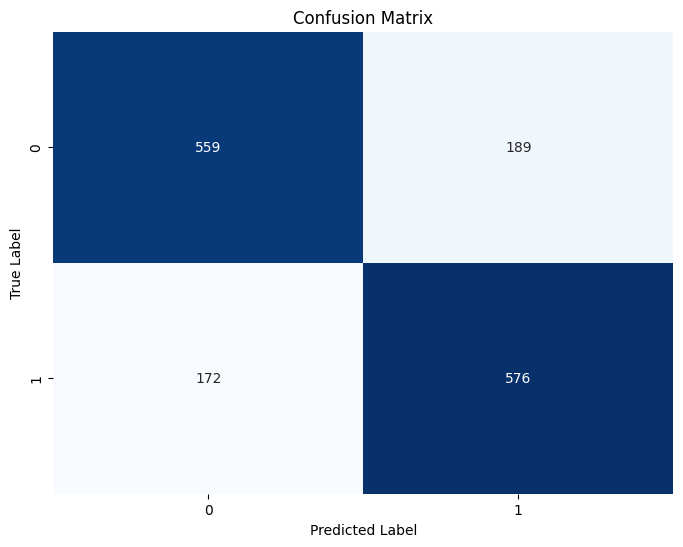

In [26]:
# Define stacking
cv = StratifiedKFold(n_splits=15, shuffle=True)

stacked_model = StackingClassifier(
    estimators=[
        ('xgb', best_xgb_model),
        ('cb', best_cb_model),
        ('lgbm', best_lgbm_model)
    ],
    final_estimator=LogisticRegression(),
    stack_method='auto', 
    n_jobs=-1,
    verbose=1
)

# Fit search
stacked_model.fit(X_train, y_train)

# Best Params
# print("Best Parameters:", random_search.best_params_)

# ==============================
# 4. Evaluate on Test Set
# ==============================
# best_model = random_search.best_estimator_
best_model = stacked_model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold (based on F1): {best_threshold:.2f}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Precision-Recall AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
[LightGBM] [Warning] Unknown parameter: sample_weights
Optimal Threshold (based on F1): 0.48
Calibrated Precision: 0.73
Calibrated Recall: 0.81
Calibrated F1 Score: 0.77
Calibrated ROC AUC: 0.82

Calibrated Classification Report:
               precision    recall  f1-score   support

   Not Churn       0.78      0.70      0.74       748
       Churn       0.73      0.81      0.77       748

    accuracy                           0.76      1496
   macro avg       0.76      0.76      0.75      1496
we

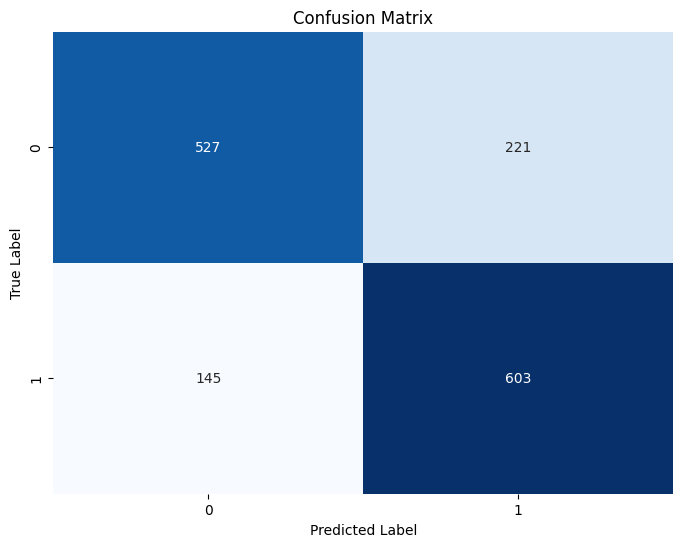

In [27]:
# ==============================
# 1. Calibrate Best Model
# ==============================
# Use isotonic calibration for best probability reliability
calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

# ==============================
# 2. Get Calibrated Probabilities
# ==============================
y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]

# ==============================
# 3. Find Optimal Threshold
# ==============================
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_cal)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold (based on F1): {best_threshold:.2f}")

# ==============================
# 4. Apply Threshold
# ==============================
y_pred_cal = (y_proba_cal >= best_threshold).astype(int)

# ==============================
# 5. Re-Evaluate Model
# ==============================
accuracy = accuracy_score(y_test, y_pred_cal)
precision = precision_score(y_test, y_pred_cal)
recall = recall_score(y_test, y_pred_cal)
f1 = f1_score(y_test, y_pred_cal)
roc_auc = roc_auc_score(y_test, y_proba_cal)

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_cal)
pr_auc = auc(recall_curve, precision_curve)

cm = confusion_matrix(y_test, y_pred_cal)

# print(f"Calibrated Accuracy: {accuracy:.2f}")
print(f"Calibrated Precision: {precision:.2f}")
print(f"Calibrated Recall: {recall:.2f}")
print(f"Calibrated F1 Score: {f1:.2f}")
print(f"Calibrated ROC AUC: {roc_auc:.2f}")
# print(f"Calibrated PR AUC: {pr_auc:.2f}")

print("\nCalibrated Classification Report:\n", classification_report(y_test, y_pred_cal, target_names=['Not Churn', 'Churn']))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [37]:
# Check if dir exists
path = os.path.join("model")
if (os.path.exists(path) is False):
    # Create models directory if it doesn't exist
    os.makedirs("models", exist_ok=True)
    

# Save the model
model_filename = f"calibrated_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
model_path = f"models/{model_filename}"

# Save the model
joblib.dump(calibrated_model, model_path)

print(f"Model saved to: {model_path}")

Model saved to: models/calibrated_model_20250910_162553.joblib


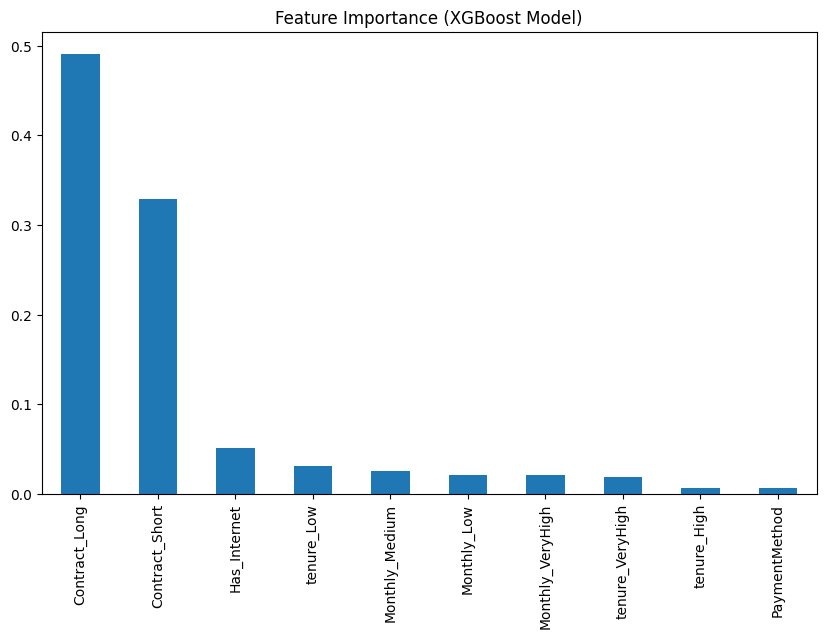

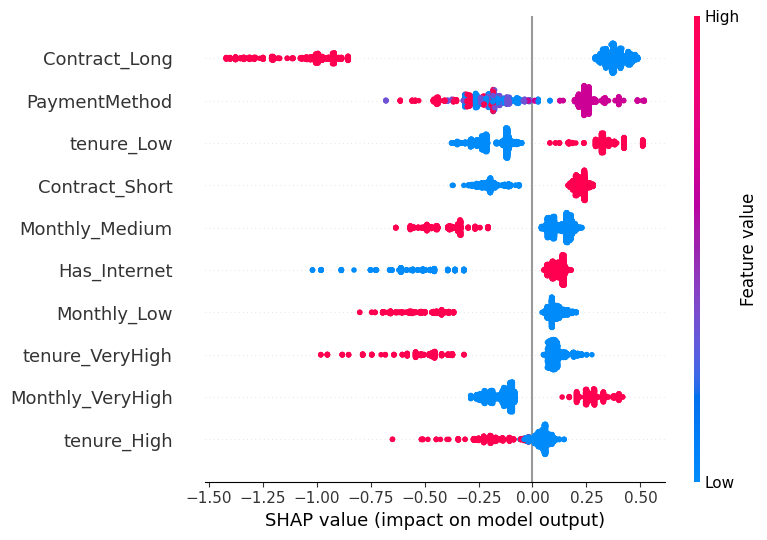

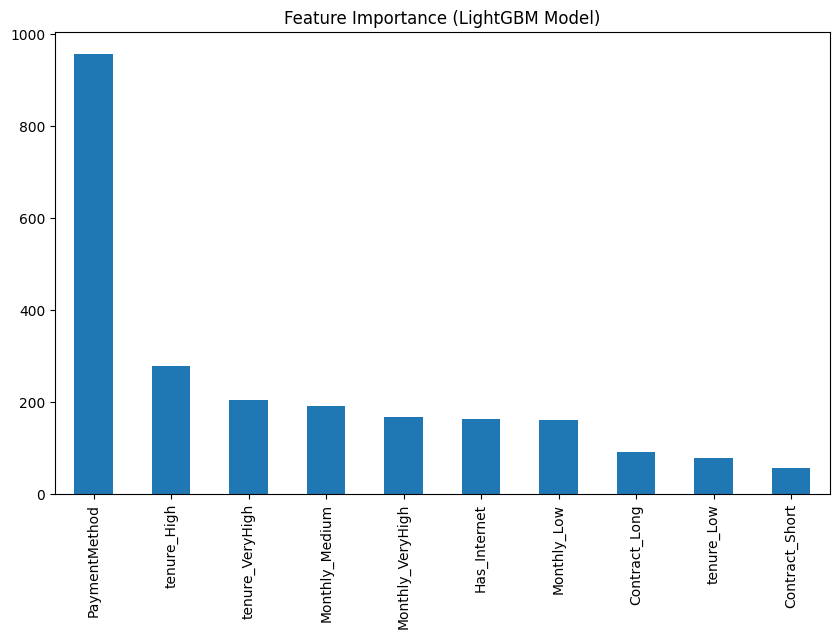

C:\Users\hitma\AppData\Roaming\Python\Python310\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


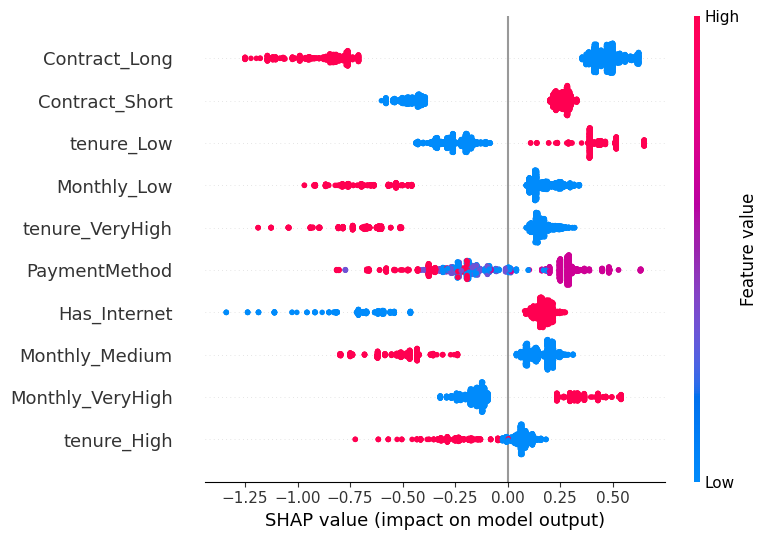

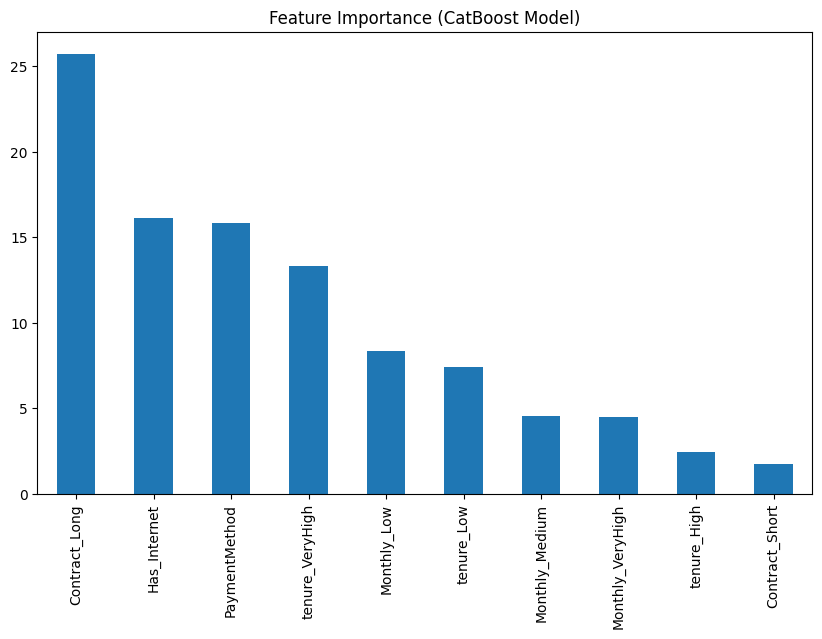

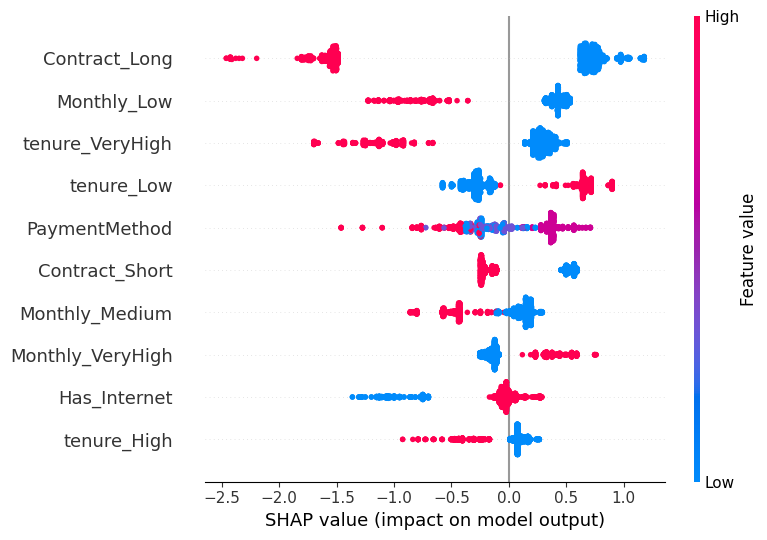

In [28]:
# ==============================
# 5. Feature Importance
# ==============================
models = {
    "XGBoost": best_xgb_model,
    "LightGBM": best_lgbm_model,
    "CatBoost": best_cb_model
}

for name, model in models.items():
    
    # Feature importance
    if hasattr(model, "feature_importances_"):  # XGB, LGBM
        importances = model.feature_importances_
    else:  # CatBoost
        importances = model.get_feature_importance()
    
    plt.figure(figsize=(10, 6))
    xgb_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    xgb_importance.plot(kind='bar', title=f'Feature Importance ({name} Model)')
    plt.show()

    # ==============================
    # 6. SHAP for Explainability
    # ==============================
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summary plot
    shap.summary_plot(shap_values, X_test)



